In [1]:
%matplotlib inline
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from itertools import islice
from torch.utils.data import DataLoader,Dataset
from functools import partial
from itertools import product

In [25]:
# k-merの一覧を作る
nt=['A', 'T', 'G', 'C']
k = 5
kmer_list=[''.join(i) for i in product(nt, repeat=k)] # k=3

# k-mer出現頻度を計算するための関数
def bin_slide(string, bin):
    l=[]
    for i in range(0, len(string)-bin+1):
        l.append(string[i:i+bin])
    return l

def calculate_ker_freq(string, bin=k):
    seq=string.upper()
    seq_kmers=bin_slide(seq, bin)
    kmer_freq=[]
    for k in kmer_list:
        # kmer_freq.append(seq_kmers.count(k)/len(seq_kmers))
        kmer_freq.append(seq_kmers.count(k))
    return np.array(kmer_freq)

def jaccard_dist(embedding1, embedding2):
    return 1 - np.sum(np.minimum(embedding1, embedding2)) / np.sum(np.maximum(embedding1, embedding2)) 

In [26]:
tmp = calculate_ker_freq("CCTACGGGAGGCAGCAGTGGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGACGGCCTTCGGGTTGTAAAGCTCTGTTAATCGGGACGAAAGGCCTTCTTGCGAATAGTTAGAAGGATTGACGGTACCGGAATAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATCAGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACCCCGTGATGGGATGGAAACTGCTGATCTAGAGTATCGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGACTTTCTGGACGAAAACTGACGCTGAGGCGCGAAAGCCAGGGGAGCGAACGGGATTAGATACCCCAGTAGTC")
tmp_2 = calculate_ker_freq("CCTACGGGAGGCTGCAGTAGGGAATCTTCGGCAATGGGGGCAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTAAGAGAAGAACGAGTGTGAGAGTGGAAAGTTCACACTGTGACGGTAACTTACCAGAAAGGGACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTC")
print(tmp)
print(tmp_2)
jaccard_dist(tmp, tmp_2)

[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]


0.6238805970149254

In [38]:
eval_align = "./eval_aligned.fa"
kmer_score = "./kmer_score.txt"

N = 20*500

def calc_kmer_score():
        cnt = 0
        with open(eval_align) as f:
            with open(kmer_score, 'w') as fo:
                while True:
                    next_n = list(islice(f, 4))
                    if not next_n:
                        break
                    if cnt >= N:
                        break
                    pair = next_n[0].strip()
                    l1 = next_n[1].strip().replace("-", "")
                    l2 = next_n[2].strip().replace("-", "")
                    score = jaccard_dist(calculate_ker_freq(l1), calculate_ker_freq(l2))
                    if score == 1.000:
                        print(l1)
                        print(l2)
                        # print(calculate_ker_freq(l1))
                        # print(calculate_ker_freq(l2))
                        print(np.sum(np.minimum(calculate_ker_freq(l1), calculate_ker_freq(l2))))
                        print(np.sum(np.maximum(calculate_ker_freq(l1), calculate_ker_freq(l2))))
                        break
                    fo.write('{}\t{:.4f}\n'.format(pair, score)) 
                        

In [39]:
np.set_printoptions(threshold=np.inf)
calc_kmer_score()

GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUCCCAGUGGGUCCA
GCGGGUGUAGUUUAGUGGUAAAACCUCAGCCUUCCAAGCUGAUGUCGUGGGUUCGAUUCCCAUCACCCGCU
0
19


In [3]:
def my_plot(align_dist_df, x_dist_df, save_fp):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=15)
    hb = ax.hexbin(align_dist_df[1], x_dist_df[1], 
                   gridsize=200, bins='log', cmap='Blues', extent=(0, 1, 0, 1))
                #    vmin=0, vmax=4)
    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'r')
    ax.set_xlabel('alignment distance', fontsize=20)
    ax.set_ylabel('k-mer(k=5)', fontsize=20)
    
    cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar_ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('log10(count + 1)', fontsize=20)
    fig.savefig(save_fp, bbox_inches='tight')    

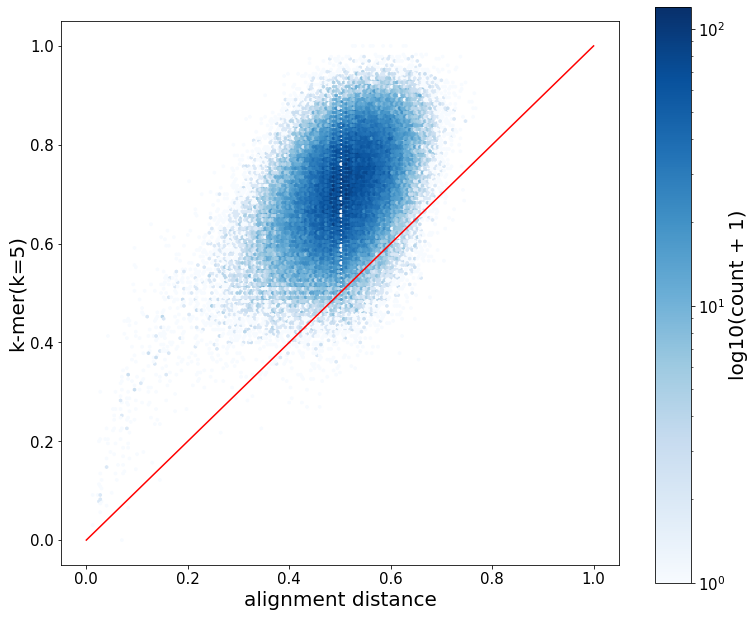

In [5]:
# evaluation
NUM_EVAL_N = 500 # number of eval pairs is N*(N-1)/2
nw_df = pd.read_csv('./eval_dist.txt', sep='\t', header=None)
my_df = pd.read_csv('./kmer_score_3.txt', sep='\t', header=None)
my_plot(nw_df, my_df, save_fp='./kmer_5.png')

In [23]:
df = pd.concat([nw_df, my_df[1]], axis=1)
df.columns = ["pair", "nw", "embedding"]
df["MSE"] = (df["nw"] - df["embedding"])**2
df["MSE"].mean()

0.22074785591927207

In [24]:
df.corr()

,nw,embedding,MSE
nw,1.000000,0.340036,-0.793894
embedding,0.340036,1.000000,0.290556
MSE,-0.793894,0.290556,1.000000


In [6]:
alignment_dist = []
with open('./eval_dist.txt') as f:
    while True:
        next_n = list(islice(f, 1))
        if not next_n:
            break
        alignment_dist.append(float(next_n[0].split("\t")[-1].strip()))

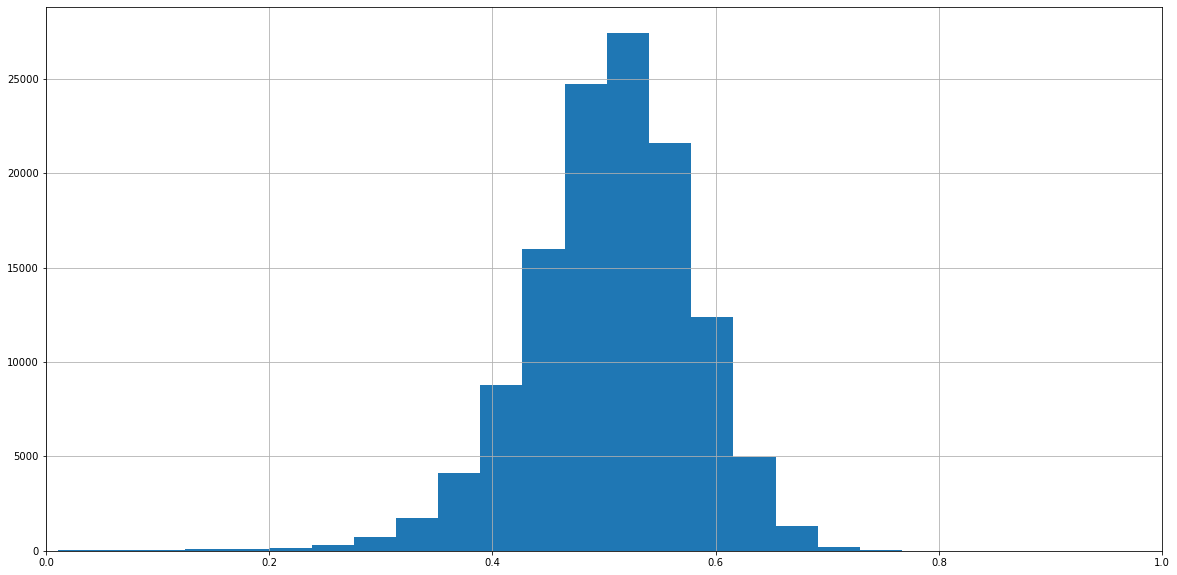

In [7]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 1)
plt.grid(True)
plt.hist(alignment_dist, rwidth=100, bins=20)
plt.savefig("./hist.png", bbox_inches='tight')